In [1]:
# # Install nightly package for some functionalities that aren't in alpha
#!pip install tensorflow-gpu==2.0.0-beta1

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.5'


ERROR: Invalid requirement: "'tensorflow-hub"


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




C:\Users\sailw\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sailw\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sailw\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sailw\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [3]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.4.0-dev20200910
Eager mode:  True
Hub version:  0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [4]:
zip_file = "C:\\Users\\sailw\\Desktop\\Plant Disease\\original dataset\\"


In [5]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

print(train_dir)

C:\Users\sailw\Desktop\Plant Disease\original dataset\PlantVillage\train


In [6]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [7]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : C:\Users\sailw\Desktop\Plant Disease\original dataset\PlantVillage\train : 70295files
total images for validation : C:\Users\sailw\Desktop\Plant Disease\original dataset\PlantVillage\validation : 17572files


In [8]:
classes = ['Apple scab', 'Apple Black rot', 'Apple Cedar rust', 'Apple healthy', 
           'Blueberry healthy','Cherry healthy','Cherry Powdery mildew','Corn Cercospora Gray leaf spot',
           'Corn Common rust','Corn healthy','Corn Northern Leaf Blight',  'Grape Black rot','Grape Esca Black Measles',
           'Grape healthy',  'Grape Leaf blight Isariopsis','Orange Haunglongbing Citrus greening',
           'Peach Bacterial spot', 'Peach healthy','Pepper bell Bacterial spot', 'Pepper bell healthy', 
           'Potato Early blight', 'Potato healthy','Potato Late blight', 'Raspberry healthy', 'Soybean healthy', 
           'Squash Powdery mildew','Strawberry healthy','Strawberry Leaf scorch', 'Tomato Bacterial spot', 
           'Tomato Early blight','Tomato healthy', 'Tomato Late blight', 'Tomato Leaf Mold','Tomato Septoria leaf spot',
           'Tomato Two spotted spider mite', 'Tomato Target Spot','Tomato mosaic virus', 'Tomato Yellow Leaf Curl Virus']

In [9]:
print('Number of classes:',len(classes))

Number of classes: 38


###Setup Image shape and  batch size

In [10]:


IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

In [11]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)
#https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

Found 17572 images belonging to 38 classes.
Found 70295 images belonging to 38 classes.


In [12]:

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/3", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



In [14]:
#print(model.summary())

In [15]:

EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/10
1098/1098 [==============================] - 1371s 1s/step - loss: 0.7275 - acc: 0.6752 - val_loss: 0.3066 - val_acc: 0.9017
Epoch 2/10
1098/1098 [==============================] - 1349s 1s/step - loss: 0.4554 - acc: 0.8478 - val_loss: 0.2699 - val_acc: 0.9113
Epoch 3/10
1098/1098 [==============================] - 1334s 1s/step - loss: 0.4156 - acc: 0.8625 - val_loss: 0.2330 - val_acc: 0.9238
Epoch 4/10
1098/1098 [==============================] - 1310s 1s/step - loss: 0.3898 - acc: 0.8697 - val_loss: 0.2143 - val_acc: 0.9299
Epoch 5/10
1098/1098 [==============================] - 1313s 1s/step - loss: 0.3776 - acc: 0.8743 - val_loss: 0.2190 - val_acc: 0.9264
Epoch 6/10
1098/1098 [==============================] - 1323s 1s/step - loss: 0.3610 - acc: 0.8791 - val_loss: 0.2073 - val_acc: 0.9301
Epoch 7/10
1098/1098 [==============================] - 1324s 1s/step - loss: 0.3578 - acc: 0.8833 - val_loss: 0.2203 - val_acc: 0.9270
Epoch 8/10
1098/1098 [==========================

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report

predictions = model.predict_generator(validation_generator,  17572 // BATCH_SIZE+1)

y_pred = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())   

print(class_labels)

print(confusion_matrix(validation_generator.classes, y_pred))




['Apple Black rot', 'Apple Cedar rust', 'Apple healthy', 'Apple scab', 'Blueberry healthy', 'Cherry Powdery mildew', 'Cherry healthy', 'Corn Cercospora Gray leaf spot', 'Corn Common rust', 'Corn Northern Leaf Blight', 'Corn healthy', 'Grape Black rot', 'Grape Esca (Black Measles)', 'Grape Leaf blight (Isariopsis Leaf Spot)', 'Grape healthy', 'Orange Haunglongbing (Citrus greening)', 'Peach Bacterial spot', 'Peach healthy', 'Pepper bell Bacterial spot', 'Pepper bell healthy', 'Potato Early blight', 'Potato Late blight', 'Potato healthy', 'Raspberry healthy', 'Soybean healthy', 'Squash Powdery mildew', 'Strawberry Leaf scorch', 'Strawberry healthy', 'Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Target Spot', 'Tomato Two spotted spider mite', 'Tomato Yellow Leaf Curl Virus', 'Tomato healthy', 'Tomato mosaic virus']
[[493   0   1 ...   0   0   0]
 [  5 423   1 ...   0   0   1]
 [  1   0 482 ...   0   0   0]
 .

In [17]:
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

                                          precision    recall  f1-score   support

                         Apple Black rot       0.93      0.99      0.96       497
                        Apple Cedar rust       0.98      0.96      0.97       440
                           Apple healthy       0.97      0.96      0.96       502
                              Apple scab       0.95      0.93      0.94       504
                       Blueberry healthy       0.97      0.98      0.98       454
                   Cherry Powdery mildew       0.99      0.97      0.98       421
                          Cherry healthy       0.98      0.99      0.98       456
          Corn Cercospora Gray leaf spot       0.96      0.86      0.91       410
                        Corn Common rust       0.98      1.00      0.99       477
               Corn Northern Leaf Blight       0.89      0.95      0.92       477
                            Corn healthy       1.00      1.00      1.00       465
               

In [18]:
conf_mat = confusion_matrix(validation_generator.classes, y_pred)

In [19]:
import numpy as np
import pandas as pd

df = pd.DataFrame(data=conf_mat)
df.to_csv('outfile.csv', sep=' ', header=False,index=False)

In [20]:
model.metrics_names

['loss', 'acc']

In [21]:
import matplotlib.pylab as plt
import numpy as np
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(EPOCHS)],history.history['acc'],'-o',c='k',lw=2)
plt.grid(True)
plt.title("Training accuracy with epoches\n",fontsize=18)
plt.xlabel("Training epoches",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

<Figure size 700x400 with 1 Axes>

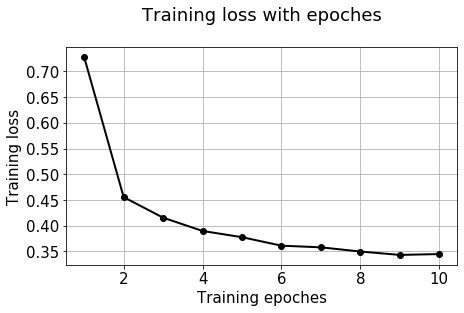

In [22]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(EPOCHS)],history.history['loss'],'-o',c='k',lw=2)
plt.grid(True)
plt.title("Training loss with epoches\n",fontsize=18)
plt.xlabel("Training epoches",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

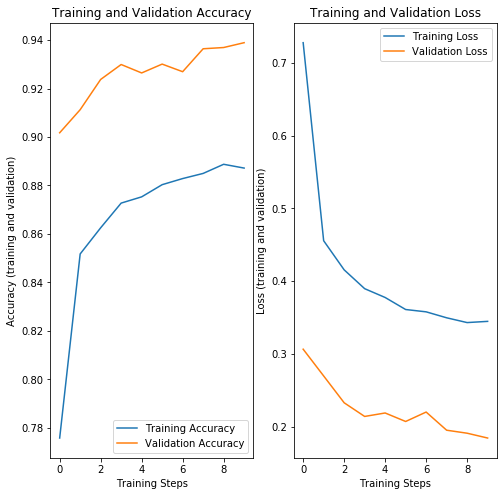

In [23]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [26]:
model.save("path")